In [ ]:
# Given a fixed number of assets available for response, how often do we approach 10%, 25% and 50% of resources being used.
# When was the highest percent of resources used and for how long?
# What happens to overall response times when these occur?
# What stations are consistently at the highest % time of resources being used?
# Is it because they are handling their own calls or another area’s?

In [1]:
import pandas as pd
from pprint import pprint
import boto3
import os
from io import StringIO
import matplotlib.pyplot as plt
import numpy as np
import statistics
%matplotlib inline

In [2]:
client = boto3.client('s3')
bucket_name = 'rescue-me-team-bucket'
object_key = 'data/GMU_2021_Summer_Capacity.csv'
csv_obj = client.get_object(Bucket=bucket_name, Key=object_key)
body = csv_obj['Body']
csv_string = body.read().decode('utf-8')

capacity_df = pd.read_csv(StringIO(csv_string))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# mark unit types
def mark_unit_type(x):
    if x[0]=='A':
        return 'ambulance'
    elif x[0]=='E':
        return 'engine'
    elif x[0]=='M':
        return 'medic'
    elif x[0]=='R':
        return 'rescue squad'
    elif x[:2] in ['TT','TL'] or x[0] == 'T':
        return 'truck/tiller/tower'
    
    # nothing picked up return none
    return 'unknown'

lookup_table={
'AK':'acknowledge',
'AM':'available on mobile (cell phone)',
'AQ':'available in quarters (station)',
'AR':'available on radio',
'DP':'dispatched',
'ER':'enroute',
'OS':'on-scene',
'OT':'out of service',
'TA':'transport arrived (at medical facility)',
'TR':'transport (begins)',
'WP':'with patient'
}
pprint(lookup_table)

{'AK': 'acknowledge',
 'AM': 'available on mobile (cell phone)',
 'AQ': 'available in quarters (station)',
 'AR': 'available on radio',
 'DP': 'dispatched',
 'ER': 'enroute',
 'OS': 'on-scene',
 'OT': 'out of service',
 'TA': 'transport arrived (at medical facility)',
 'TR': 'transport (begins)',
 'WP': 'with patient'}


In [5]:
capacity_df['status_desc']=capacity_df['CAD_UnitStatus'].map(lookup_table)
capacity_df['day']=capacity_df['CAD_Timestamp'].str[:8]

# cleanup string issues
capacity_df['UnitBattalion']=capacity_df['UnitBattalion'].astype(str)
capacity_df['UnitStation']=capacity_df['UnitStation'].astype(str)
capacity_df['unit_type'] = capacity_df.apply(lambda x: mark_unit_type(x['CAD_UnitID']), axis=1)

capacity_df

# check for duplicates
# capacity_df[capacity_df.duplicated(keep=False)]

,IncidentNumber,CallConfirmedDT,IncidentCategory,IncidentBattalion,IncidentFirstDue,CAD_UnitID,UnitBattalion,UnitStation,CAD_Timestamp,CAD_UnitStatus,Shift,status_desc,day,unit_type
0,E170010002,2017-01-01 00:01:10,E,NaN,NaN,E410,408,10,20170101000307ES,ER,C,enroute,20170101,engine
1,E170010002,2017-01-01 00:01:10,E,NaN,NaN,E410,408,10,20170101000926ES,WP,C,with patient,20170101,engine
2,E170010002,2017-01-01 00:01:10,E,NaN,NaN,M410B,408,10,20170101012905ES,CU,C,NaN,20170101,medic
3,E170010008,2017-01-01 00:01:01,F,401.0,439.0,E439,401,39,20170101000302ES,DP,C,dispatched,20170101,engine
4,E170010008,2017-01-01 00:01:01,F,401.0,439.0,TT425,401,25,20170101000520ES,ER,C,enroute,20170101,truck/tiller/tower
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4420055,E203662405,2020-12-31 23:47:48,E,408.0,422.0,M422,408,22,20210101001603ES,TA,A,transport arrived (at medical facility),20210101,medic
4420056,E203662422,2020-12-31 23:56:27,E,402.0,444.0,E413,402,13,20210101000330ES,OS,A,on-scene,20210101,engine
4420057,E203662422,2020-12-31 23:56:27,E,402.0,444.0,M413,402,13,20201231235831ES,DP,A,dispatched,20201231,medic
4420058,E203662422,2020-12-31 23:56:27,E,402.0,444.0,M413,402,13,20210101000427ES,WP,A,with patient,20210101,medic


In [7]:
capacity_df.isna().sum()

IncidentNumber            0
CallConfirmedDT           0
IncidentCategory          0
IncidentBattalion    180386
IncidentFirstDue     126236
CAD_UnitID                0
UnitBattalion             0
UnitStation               0
CAD_Timestamp             0
CAD_UnitStatus            0
Shift                     0
status_desc          344967
day                       0
unit_type                 0
dtype: int64

In [8]:
capacity_df[capacity_df['status_desc'].isna()]['CAD_UnitStatus'].unique()

array(['CU', '~', 'UE', 'UU', 'UC', 'CL', 'UT', 'SC', 'SX', 'XB', 'XC',
       'XE', 'DW', 'UG', 'AV', '1R', 'UV', 'RB', 'TU', 'AF'], dtype=object)

In [9]:
capacity_df[capacity_df['CAD_UnitStatus']=='~']

,IncidentNumber,CallConfirmedDT,IncidentCategory,IncidentBattalion,IncidentFirstDue,CAD_UnitID,UnitBattalion,UnitStation,CAD_Timestamp,CAD_UnitStatus,Shift,status_desc,day,unit_type
29,E170010055,2017-01-01 00:20:24,F,402.0,429.0,E413,402,13,20170101002417ES,~,C,NaN,20170101,engine
66,E170010162,2017-01-01 00:55:40,E,401.0,425.0,E425,401,25,20170101005943ES,~,C,NaN,20170101,engine
75,E170010008,2017-01-01 00:01:01,F,401.0,439.0,TT425,401,25,20170101000503ES,~,C,NaN,20170101,truck/tiller/tower
89,E170010032,2017-01-01 00:12:10,E,NaN,201.0,M411,406,11,20170101004818ES,~,C,NaN,20170101,medic
126,E170010141,2017-01-01 00:49:16,F,403.0,438.0,E438,403,38,20170101005218ES,~,C,NaN,20170101,engine
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419855,E203661740,2020-12-31 18:30:31,E,403.0,417.0,M440,407,40,20201231183525ES,~,A,NaN,20201231,medic
4419929,E203662024,2020-12-31 20:27:10,E,403.0,431.0,M431,403,31,20201231204840ES,~,A,NaN,20201231,medic
4420005,E203662268,2020-12-31 22:41:09,E,406.0,411.0,T411,406,11,20201231233130ES,~,A,NaN,20201231,truck/tiller/tower
4420012,E203662281,2020-12-31 22:50:44,E,406.0,NaN,E437,406,37,20201231225443ES,~,A,NaN,20201231,engine


In [10]:
# 4 year timespan
print('min time:',capacity_df['CAD_Timestamp'].min())
print('max time:',capacity_df['CAD_Timestamp'].max())

min time: 20170101000137ES
max time: 20210101004928ES


In [11]:
capacity_df['IncidentNumber'].nunique() # ~100 k unique incidents

407569

In [12]:
print('# unique Battalions:',capacity_df['UnitBattalion'].nunique()) # 17 unique Battalions
capacity_df['UnitBattalion'].unique()

# unique Battalions: 9


array(['408', '401', '406', '403', '404', '402', '405', '407',
       'Training Academy'], dtype=object)

In [13]:
capacity_df['IncidentBattalion'].unique()

array([ nan, 401., 406., 403., 404., 402., 408., 405., 407., 443., 465.])

In [14]:
print('# unique first due:',capacity_df['IncidentFirstDue'].nunique())
capacity_df['IncidentFirstDue'].unique()

# unique first due: 109


array([  nan,  439.,  425.,  424.,  417.,  428.,  201.,  430.,  404.,
        429.,  422.,  435.,  409.,  408.,  411.,  401.,  102.,  438.,
        208.,  423.,  426.,  414.,  106.,  412.,  418.,  434.,  415.,
        413.,  421.,  618.,  442.,  419.,  101.,  204.,  410.,  432.,
        437.,  431.,  402.,  405.,  427.,  416.,  440.,  210.,  108.,
        433.,  403.,  436.,  611.,  441.,  619.,  420.,  821.,  827.,
        464.,  502.,  206.,  607.,  209.,  624.,  302.,  205.,  842.,
        207.,  109.,  700.,  107.,  829.,  465.,  103.,  511.,  463.,
        508.,  203.,  623.,  105.,  847.,  303.,  104.,  832.,  512.,
        526.,  514.,  825.,  609., 9800.,  466.,  504.,  569.,  510.,
        507.,  525.,  524.,  110.,  520.,  521.,  824.,  627.,  622.,
        523.,  444.,  606.,  710.,  601.,  301.,  620.,  161.,  516.,
        823.,  800.])

In [15]:
print('# unique unit station:',capacity_df['UnitStation'].nunique()) # 77 unique stations
capacity_df['UnitStation'].unique()

# unique unit station: 45


array(['10', '39', '25', '24', '17', '28', '11', '30', '36', '13', '29',
       '22', '35', '9', '8', '26', '1', '38', '5', '31', '23', '37', '4',
       '14', '27', '12', '18', '34', '15', '21', '40', '42', '19', '41',
       '20', '32', '2', '16', '05', '01', '08', '09', '04', '02', 'TA'],
      dtype=object)

In [16]:
print('# unique CAD unitID:',capacity_df['CAD_UnitID'].nunique()) # 171 unique units
capacity_df['CAD_UnitID'].unique()

# unique CAD unitID: 171


array(['E410', 'M410B', 'E439', 'TT425', 'E425', 'M425', 'E424', 'M424',
       'E417', 'M417', 'E428', 'M428', 'M411', 'E430', 'M439', 'R439',
       'TL436', 'M411B', 'E413', 'E429', 'M413', 'M430', 'E422', 'T422',
       'E435', 'E409', 'T424', 'E408', 'M408', 'E426', 'M408B', 'M401',
       'M426', 'E438', 'T438', 'M405', 'R426', 'M431', 'E423', 'M429',
       'TT429', 'E411', 'R411', 'M438', 'M423', 'E437', 'M404', 'T411',
       'M422', 'M414', 'R414', 'M427', 'E412', 'M418', 'M434', 'M415',
       'M435', 'E421', 'TL440', 'M412', 'E415', 'E434', 'E442', 'M442',
       'M409', 'E414', 'E419', 'M419', 'M410', 'T441', 'E418', 'R418',
       'E420', 'E432', 'M432', 'E405', 'M402', 'E402', 'E431', 'E404',
       'R401', 'TL430', 'T405', 'E401', 'M416', 'M409B', 'M437', 'E427',
       'E416', 'E436', 'R419', 'M440', 'TT410', 'TL401', 'E440', 'TL408',
       'M421', 'A410', 'M436', 'A437E', 'A422E', 'A413E', 'R421', 'M422B',
       'M405E', 'M420', 'A402E', 'E441', 'M441', 'TL405', 'A4

In [17]:
print(capacity_df['unit_type'].nunique())
capacity_df['unit_type'].unique()

5


array(['engine', 'medic', 'truck/tiller/tower', 'rescue squad',
       'ambulance'], dtype=object)

In [18]:
%%time
def process_df(df):
    # intialize values for the whole fleet
    current_dict={}
    day_max_dict={}
    return_set=set(['AM','AQ','AR'])
    max_deployment=0
    current_deploy_per=0.0
    prev_deploy_per=0.0
    count_10,count_25,count_50=0,0,0
    unique_unit_count=df['CAD_UnitID'].nunique()

    # deep only dispatch or available events
    temp_df=df[capacity_df['CAD_UnitStatus'].isin(['AM','AQ','AR','DP'])]
    # sort entire df
    temp_df.sort_values(by=['CAD_Timestamp'])

    # loop through every element in df
    for index, row in temp_df.sort_values(by=['CAD_Timestamp'])[:].iterrows():    
        # if dispatched add unit to collection of dispatched units
        if row['CAD_UnitStatus']=='DP':
            # add to master dictionary
            current_dict[row['CAD_UnitID']]=row    
        # if AM, AQ, or AR then release
        elif row['CAD_UnitStatus'] in return_set:
            # remove from master dictionary
            if row['CAD_UnitID'] in current_dict:
                del current_dict[row['CAD_UnitID']]

        # check length of set vs. max
        current_num = len(current_dict)
        if current_num > max_deployment:
            max_deployment=len(current_dict) # record a new max number of unique units deployed
            print('new max deployed #:',len(current_dict),row['CAD_Timestamp'])
            max_dict = current_dict.copy() # copy all the units deployed at the new max

        # populate the dict that will track the max % deployed per day
        current_deploy_per=current_num/unique_unit_count
        if row['day'] not in day_max_dict:
            day_max_dict[row['day']]=current_deploy_per
        else:
            if current_deploy_per > day_max_dict[row['day']]:
                day_max_dict[row['day']]=current_deploy_per

    # print('\n','max len dict:',len(max_dict))
    for i,v in max_dict.items():
        print(i,'|',v['CAD_Timestamp'][0:4],v['CAD_Timestamp'][4:6],v['CAD_Timestamp'][6:8],v['CAD_Timestamp'])
    
    # return a dictionary with the max % deployed by day, as well as a count of the max # deployed
    return day_max_dict, max_deployment


CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.3 µs


In [19]:
# essential medics are 8,9,10,11
medics_to_remove=['M422B', 'M427B', 'M402B','M414B', 'M417B', 'M401B'] # should leave 42? we see 50.  Also 48, not 38 engines
# filter to essential units
# capacity_df[(capacity_df['unit_type']=='engine')|(capacity_df['unit_type']=='medic')]['CAD_UnitID'].unique()
#capacity_df[(capacity_df['unit_type']=='medic') & ~(capacity_df['CAD_UnitID'].isin(medics_to_remove))]['CAD_UnitID'].nunique()
# capacity_df[(capacity_df['unit_type']=='engine')]['CAD_UnitID'].unique()
essential_df=capacity_df[(capacity_df['unit_type']=='engine')|((capacity_df['unit_type']=='medic') & ~(capacity_df['CAD_UnitID'].isin(medics_to_remove)))]

In [20]:
%%time
overall_day_max_dict,overall_max_deployment=process_df(capacity_df)
# overall_day_max_dict
essential_day_max_dict,essential_max_deployment=process_df(essential_df)
ambulance_day_max_dict,ambulance_max_deployment=process_df(capacity_df[capacity_df['unit_type']=='ambulance'])
engine_day_max_dict,engine_max_deployment=process_df(capacity_df[capacity_df['unit_type']=='engine'])
medic_day_max_dict,medic_max_deployment=process_df(capacity_df[capacity_df['unit_type']=='medic'])
rescue_day_max_dict,rescue_max_deployment=process_df(capacity_df[capacity_df['unit_type']=='rescue squad'])
ttt_day_max_dict,ttt_max_deployment=process_df(capacity_df[capacity_df['unit_type']=='truck/tiller/tower'])

new max deployed #: 1 20170101000137ES
new max deployed #: 2 20170101000137ES
new max deployed #: 3 20170101000302ES
new max deployed #: 4 20170101000303ES
new max deployed #: 5 20170101000523ES
new max deployed #: 6 20170101000524ES
new max deployed #: 7 20170101000801ES
new max deployed #: 8 20170101000802ES
new max deployed #: 9 20170101001142ES
new max deployed #: 10 20170101001143ES
new max deployed #: 11 20170101001223ES
new max deployed #: 12 20170101001224ES
new max deployed #: 13 20170101001309ES
new max deployed #: 14 20170101001433ES
new max deployed #: 15 20170101001434ES
new max deployed #: 16 20170101001514ES
new max deployed #: 17 20170101001515ES
new max deployed #: 18 20170101001612ES
new max deployed #: 19 20170101003307ES
new max deployed #: 20 20170101003407ES
new max deployed #: 21 20170101003408ES
new max deployed #: 22 20170101003448ES
new max deployed #: 23 20170101003525ES
new max deployed #: 24 20170101003614ES
new max deployed #: 25 20170101010018ES
new max d

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


new max deployed #: 1 20170101000137ES
new max deployed #: 2 20170101000137ES
new max deployed #: 3 20170101000302ES
new max deployed #: 4 20170101000523ES
new max deployed #: 5 20170101000524ES
new max deployed #: 6 20170101000801ES
new max deployed #: 7 20170101000802ES
new max deployed #: 8 20170101001142ES
new max deployed #: 9 20170101001143ES
new max deployed #: 10 20170101001223ES
new max deployed #: 11 20170101001224ES
new max deployed #: 12 20170101001309ES
new max deployed #: 13 20170101001433ES
new max deployed #: 14 20170101001434ES
new max deployed #: 15 20170101001515ES
new max deployed #: 16 20170101003407ES
new max deployed #: 17 20170101003408ES
new max deployed #: 18 20170101003448ES
new max deployed #: 19 20170101003525ES
new max deployed #: 20 20170101003614ES
new max deployed #: 21 20170101005737ES
new max deployed #: 22 20170101010018ES
new max deployed #: 23 20170101010206ES
new max deployed #: 24 20170101140356ES
new max deployed #: 25 20170102183501ES
new max d

M440 | 2018 01 09 20180109092937ES
M429 | 2018 01 09 20180109093027ES
M430 | 2018 01 09 20180109093234ES
M426 | 2018 01 09 20180109093307ES
M411 | 2018 01 09 20180109093354ES
M441 | 2018 01 09 20180109094405ES
M416 | 2018 01 09 20180109094449ES
M415 | 2018 01 09 20180109094704ES
M422 | 2018 01 09 20180109095350ES
M402 | 2018 01 09 20180109095722ES
M409 | 2018 01 09 20180109100031ES
M408 | 2018 01 09 20180109100843ES
M437 | 2018 01 09 20180109101012ES
M410B | 2018 01 09 20180109101214ES
M438 | 2018 01 09 20180109101326ES
M432 | 2018 01 09 20180109101905ES
M418 | 2018 01 09 20180109101947ES
M420 | 2018 01 09 20180109102036ES
M408B | 2018 01 09 20180109102539ES
M404 | 2018 01 09 20180109102725ES
M439 | 2018 01 09 20180109103051ES
M405 | 2018 01 09 20180109103447ES
M401 | 2018 01 09 20180109103600ES
M442 | 2018 01 09 20180109104216ES
M424 | 2018 01 09 20180109104605ES
M411B | 2018 01 09 20180109104638ES
M417 | 2018 01 09 20180109104819ES
M431 | 2018 01 09 20180109105322ES
M409B | 2018 01 0

In [21]:
# clean up all dictionaries
# loop through all possible days
def fill_in_blanks(in_dict,day_list):
    temp_dict=in_dict.copy()
    counter=0
    for i in day_list:
        counter+=1
        day=str(i)
        if day not in temp_dict:
            temp_dict[day]=0.0
    print('counter:',counter)
    return temp_dict
day_list=overall_day_max_dict.keys()
ambulance_day_max_dict=fill_in_blanks(ambulance_day_max_dict,day_list)
rescue_day_max_dict=fill_in_blanks(rescue_day_max_dict,day_list)
ttt_day_max_dict=fill_in_blanks(ttt_day_max_dict,day_list)
essential_day_max_dict=fill_in_blanks(essential_day_max_dict,day_list)
#pprint(ttt_day_max_dict)
# should have 1462 days total
# show all lens
print('overall:',len(overall_day_max_dict))
print('ambulance:',len(ambulance_day_max_dict))
print('engine:',len(engine_day_max_dict))
print('medic:',len(medic_day_max_dict))
print('rescue:',len(rescue_day_max_dict))
print('ttt:',len(ttt_day_max_dict))
print('essential:',len(essential_day_max_dict))

counter: 1462
counter: 1462
counter: 1462
counter: 1462


1462

In [25]:
def basic_stats(dict):
    print('mean max deploy:',round(sum(dict.values())/len(dict.values()),3))
    print('stdev max deploy:',round(statistics.stdev(dict.values()),3))

print('overall:')
basic_stats(overall_day_max_dict)

print('ambulance:')
basic_stats(ambulance_day_max_dict)

print('engine:')
basic_stats(engine_day_max_dict)

print('medic:')
basic_stats(medic_day_max_dict)

print('rescue:')
basic_stats(rescue_day_max_dict)

print('ttt:')
basic_stats(ttt_day_max_dict)

print('essential')
basic_stats(essential_day_max_dict)

overall:
mean max deploy: 0.197
stdev max deploy: 0.032
ambulance:
mean max deploy: 0.054
stdev max deploy: 0.032
engine:
mean max deploy: 0.237
stdev max deploy: 0.049
medic:
mean max deploy: 0.354
stdev max deploy: 0.056
rescue:
mean max deploy: 0.399
stdev max deploy: 0.106
ttt:
mean max deploy: 0.155
stdev max deploy: 0.037
essential
mean max deploy: 0.294
stdev max deploy: 0.044


In [29]:
print('overall max deploy %:',round(overall_max_deployment/capacity_df['CAD_UnitID'].nunique(),3))
print('ambulance max deploy %:',round(ambulance_max_deployment/capacity_df[capacity_df['unit_type']=='ambulance']['CAD_UnitID'].nunique(),3))
print('engine max deploy %:',round(engine_max_deployment/capacity_df[capacity_df['unit_type']=='engine']['CAD_UnitID'].nunique(),3))
print('medic max deploy %:',round(medic_max_deployment/capacity_df[capacity_df['unit_type']=='medic']['CAD_UnitID'].nunique(),3))
print('rescue max deploy %:',round(rescue_max_deployment/capacity_df[capacity_df['unit_type']=='rescue squad']['CAD_UnitID'].nunique(),3))
print('ttt max deploy %:',round(rescue_max_deployment/capacity_df[capacity_df['unit_type']=='truck/tiller/tower']['CAD_UnitID'].nunique(),3))

print('essential max deploy %:',round(essential_max_deployment/essential_df['CAD_UnitID'].nunique(),3))

overall max deploy %: 0.415
ambulance max deploy %: 0.25
engine max deploy %: 0.604
medic max deploy %: 0.571
rescue max deploy %: 0.875
ttt max deploy %: 0.226
essential max deploy %: 0.582


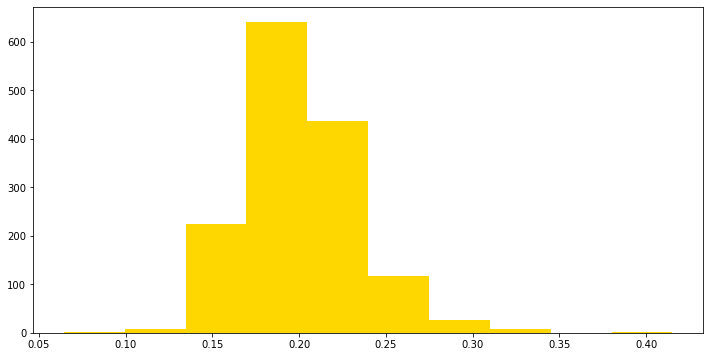

In [67]:
plt.hist(list(overall_day_max_dict.values()),color='gold')
plt.show()

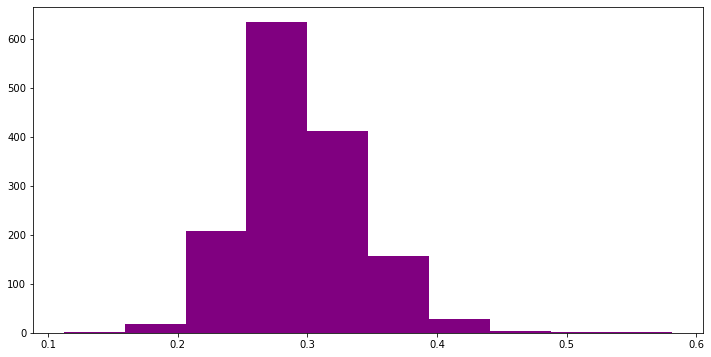

In [66]:
plt.hist(list(essential_day_max_dict.values()),color='purple')
plt.show()

In [32]:
list_max=max(essential_day_max_dict.values())
max_index=list(essential_day_max_dict.values()).index(list_max)
list(essential_day_max_dict.keys())[max_index]

'20180502'

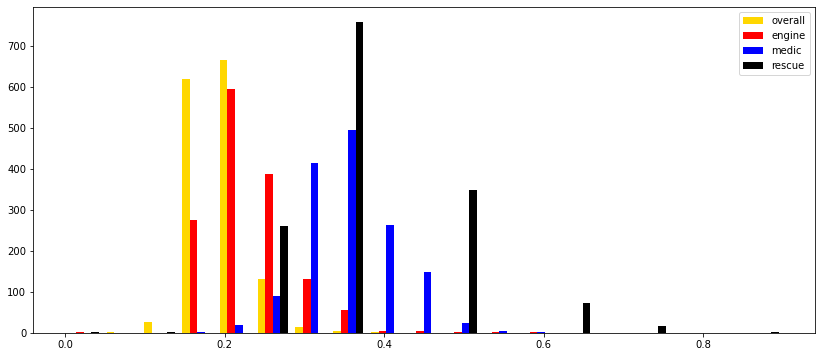

In [63]:
# engines = red, medics = blue, rescue = black
x1 = list(overall_day_max_dict.values())
x2 = list(ambulance_day_max_dict.values())
x3 = list(engine_day_max_dict.values())
x4 = list(medic_day_max_dict.values())
x5 = list(rescue_day_max_dict.values())
x6 = list(ttt_day_max_dict.values())
bins = np.linspace(0,.9,20)
colors=['gold','red','blue','black']
plt.hist([x1,x3,x4,x5], bins, label=['overall','engine','medic','rescue'],color=colors)
plt.legend(loc='upper right'),
plt.rcParams["figure.figsize"] = (12,6)
plt.show()

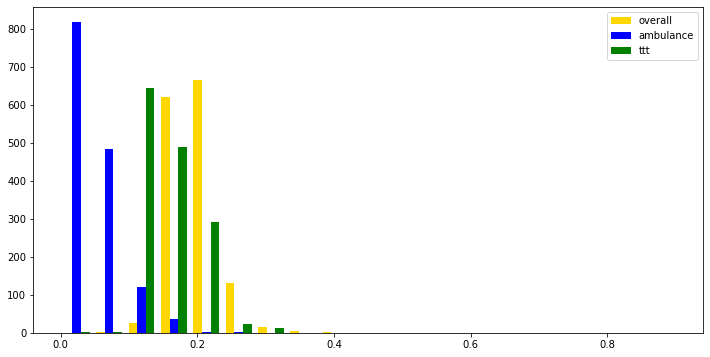

In [64]:
# truck = green, amb = blue
colors=['gold','blue','green']
plt.hist([x1,x2,x6], bins, label=['overall','ambulance','ttt'],color=colors)
plt.legend(loc='upper right')
plt.show()

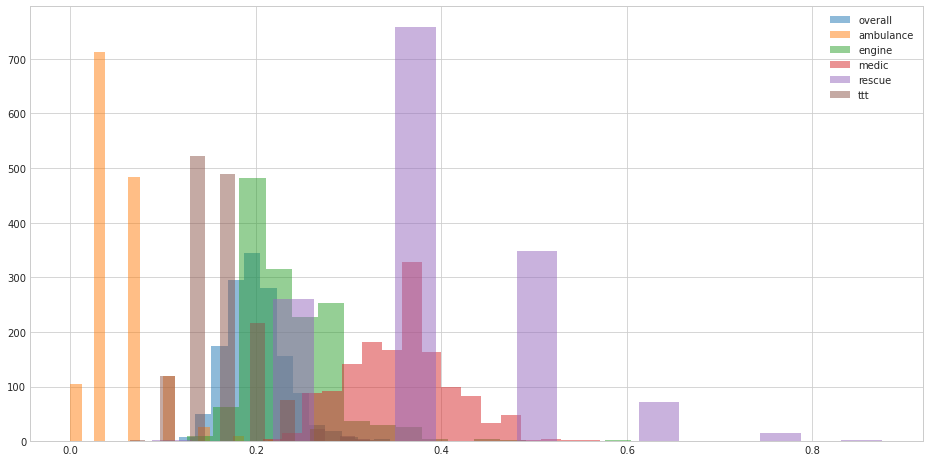

In [94]:
bins=20
plt.hist(overall_day_max_dict.values(),bins,alpha=0.5, label='overall')
plt.hist(ambulance_day_max_dict.values(),bins,alpha=0.5, label='ambulance')
plt.hist(engine_day_max_dict.values(),bins,alpha=0.5, label='engine')
plt.hist(medic_day_max_dict.values(),bins,alpha=0.5, label='medic')
plt.hist(rescue_day_max_dict.values(),bins,alpha=0.5, label='rescue')
plt.hist(ttt_day_max_dict.values(),bins,alpha=0.5, label='ttt')
plt.legend(loc='upper right')
plt.show()

In [17]:
total_days=len(overall_day_max_dict)
print('total days:',total_days)

total days: 1462


In [18]:
days_10_25=len([i for i in overall_day_max_dict.values() if i >= .1 and i < .25])
days_25_50=len([i for i in overall_day_max_dict.values() if i >= .25 and i < .5])
days_50=len([i for i in overall_day_max_dict.values() if i >= .5])

print('days 10% - 25%:',days_10_25,round(days_10_25/total_days,2))
print('days 25% - 50%:',days_25_50,round(days_25_50/total_days,2))
print('days 50%+:',days_50,round(days_50/total_days,2))

days 10% - 25%: 1376 0.94
days 25% - 50%: 85 0.06
days 50%+: 0 0.0


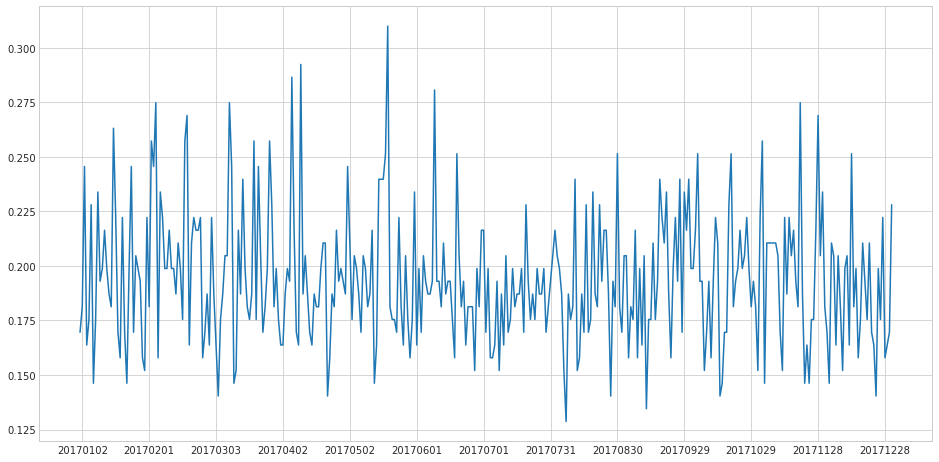

In [19]:
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [16, 8] 
fig = plt.figure()
ax = plt.axes()
ax.xaxis.set_ticks(np.arange(1, 365, 30))
ax.plot(list(overall_day_max_dict.keys())[:365], list(overall_day_max_dict.values())[:365]);

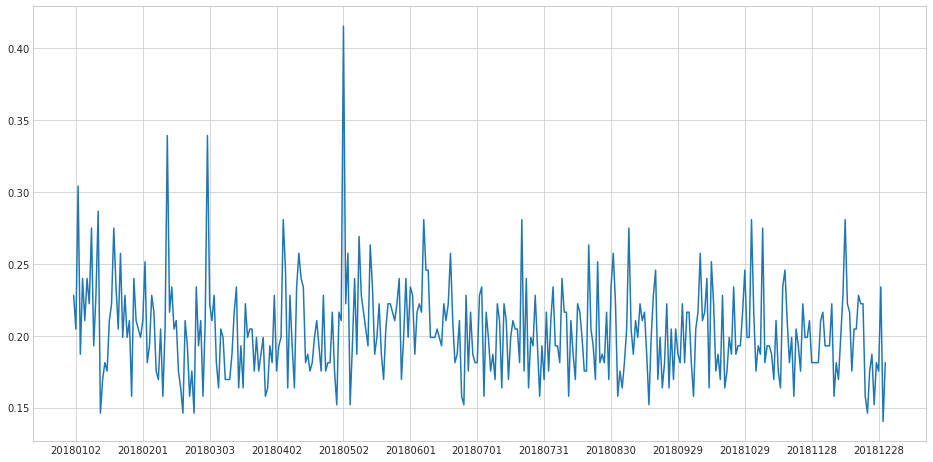

In [20]:
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [16, 8] 
fig = plt.figure()
ax = plt.axes()
ax.xaxis.set_ticks(np.arange(1, 365, 30))
ax.plot(list(overall_day_max_dict.keys())[365:365*2], list(overall_day_max_dict.values())[365:365*2]);

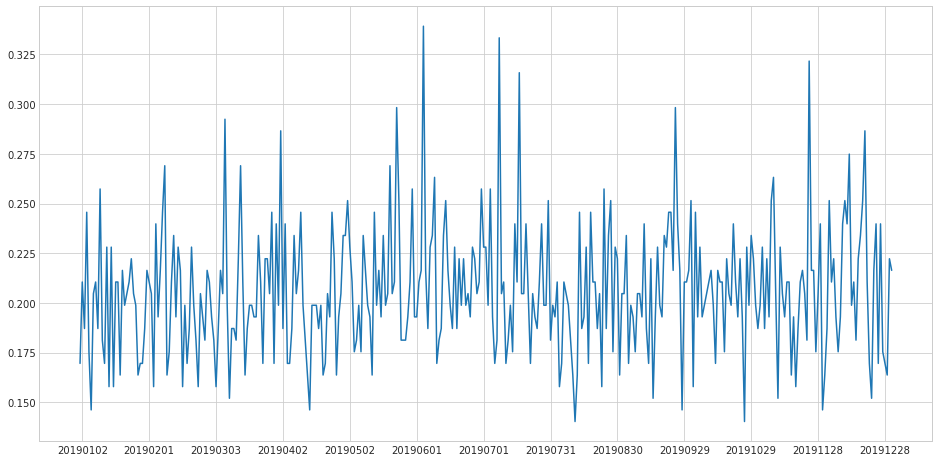

In [21]:
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [16, 8] 
fig = plt.figure()
ax = plt.axes()
ax.xaxis.set_ticks(np.arange(1, 365, 30))
ax.plot(list(overall_day_max_dict.keys())[365*2:365*3], list(overall_day_max_dict.values())[365*2:365*3]);

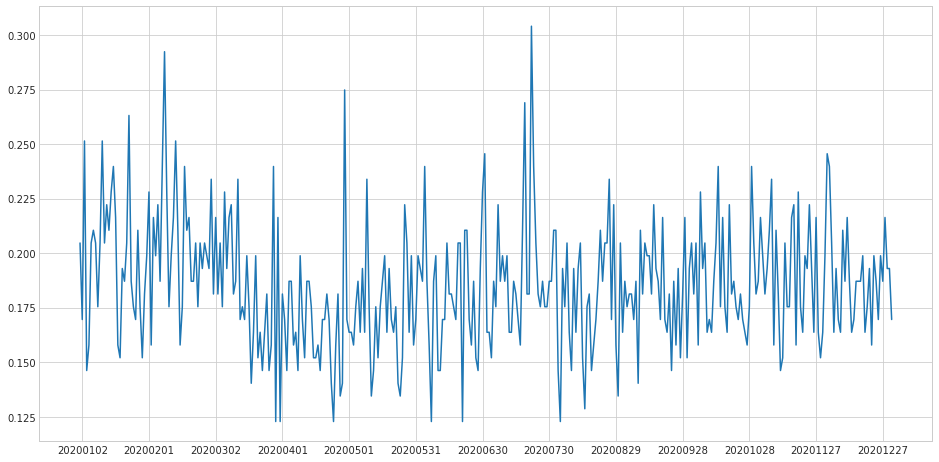

In [22]:
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [16, 8] 
fig = plt.figure()
ax = plt.axes()
ax.xaxis.set_ticks(np.arange(1, 365, 30))
ax.plot(list(overall_day_max_dict.keys())[365*3:365*4+1], list(overall_day_max_dict.values())[365*3:365*4+1]);

In [23]:
day_of_week=[]
days_of_wk=['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
week_len=len(days_of_wk)
counter=week_len
while counter < total_days:
    day_of_week+=days_of_wk
    counter+=week_len
    
diff=total_days-len(day_of_week)
day_of_week+=days_of_wk[:diff]
day_of_week[:20]

max_by_day_df = pd.DataFrame(
    {'day': overall_day_max_dict.keys(),
     'max_pct': overall_day_max_dict.values(),
     'day_of_week': day_of_week
    })
max_by_day_df

,day,max_pct,day_of_week
0,20170101,0.169591,Sunday
1,20170102,0.181287,Monday
2,20170103,0.245614,Tuesday
3,20170104,0.163743,Wednesday
4,20170105,0.175439,Thursday
...,...,...,...
1457,20201228,0.216374,Monday
1458,20201229,0.192982,Tuesday
1459,20201230,0.192982,Wednesday
1460,20201231,0.169591,Thursday


In [ ]:
# mark holidays
def mark_holidays(x):
    if x[4:]=='0101':
        return 'new years day'
    elif x[4:]=='1231':
        return 'new years eve'
    elif x[4:]=='1225':
        return 'xmas'
    elif x[4:]=='1224':
        return 'xmas eve'
    elif x[4:]=='1031':
        return 'halloween'
    elif x[4:]=='0704':
        return '4th of july'
    
    # specific thanksgiving dates
    elif x in ['20201126','20191128','20181122','20171123']:
        return 'thanksgiving'
    elif x in ['20201125','20191127','20181121','20171122']:
        return 'thanksgiving eve'
    elif x in ['20200907','20190902','20180903','20170904']:
        return 'labor day'
    elif x in ['20200525','20190527','20180528','20170529']:
        return 'memorial day'
    
    # nothing picked up return none
    return 'none'

max_by_day_df['holiday'] = max_by_day_df.apply(lambda x: mark_holidays(x['day']), axis=1)

In [ ]:
max_by_day_df[max_by_day_df['holiday']=='4th of july']

In [ ]:
new_df=max_by_day_df.groupby(['day_of_week']).mean()
res = new_df.apply(lambda x: x.sort_values(ascending=False))
print(res)
ax=res.unstack().plot.barh()
ax.invert_yaxis()

In [ ]:
new_df=max_by_day_df.groupby(['holiday']).mean()
res = new_df.apply(lambda x: x.sort_values(ascending=False))
print(res)
ax=res.unstack().plot.barh()
ax.invert_yaxis()

In [ ]:
max_df=pd.DataFrame.from_dict(max_dict.values())
max_df

In [ ]:
max_df=max_df[max_df['IncidentNumber'].isin(['E181221324','E181221450'])]
max_df[['UnitBattalion','UnitStation','CAD_UnitID','IncidentNumber']].groupby(['IncidentNumber','UnitBattalion']).agg(['count'])